# Import Packages 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats.mstats import winsorize

# Import Data 

In [64]:
df_import = pd.read_csv("BN_Melbourne_hh_2021.csv")

In [65]:
df_import.head()

,LGA,hhsize,totalvehs,dwelltype,hhinc,owndwell
0,Banyule,1.0,1.0,Other,$900,Fully Owned
1,Banyule,1.0,1.0,Separate House,"$3,625",Being Purchased
2,Banyule,2.0,1.0,Separate House,"$1,475",Fully Owned
3,Banyule,1.0,1.0,Separate House,$0,Being Purchased
4,Banyule,2.0,1.0,Separate House,"$1,225",Fully Owned


# Checking for missing data 

In [66]:
df_import["owndwell"].unique()

array(['Fully Owned', 'Being Purchased', 'Being Rented',
       'Occupied Rent-Free', 'Something Else'], dtype=object)

In [67]:
df_import["dwelltype"].unique()

array(['Other', 'Separate House', 'Terrace/Townhouse',
       'Flat or Apartment', 'Missing'], dtype=object)

In [68]:
df_import[df_import["dwelltype"] != "Missing"].describe()

,hhsize,totalvehs
count,1.854696e+06,1.854696e+06
mean,2.544069e+00,1.300504e+00
std,1.322304e+00,9.007720e-01
min,1.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,4.000000e+00,2.000000e+00
max,1.100000e+01,9.000000e+00


In [69]:
df_import[df_import["dwelltype"] == "Missing"].describe()

,hhsize,totalvehs
count,1467.000000,1467.000000
mean,2.064076,1.184049
std,1.122745,0.826863
min,1.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,5.000000,7.000000


In [70]:
missing = np.round(1467.000000/1.854696e+06*100,5)
print(f"Missing values in dwelltype: {missing}%")	

Missing values in dwelltype: 0.0791%


In [71]:
df = df_import.copy()

# Removed Missing Values 
df = df[df['dwelltype'] != 'Missing'] 

# Converted income string to float 
df['hhinc'] = df['hhinc'].replace([r',', r'\$'], '', regex=True).astype(float)

Text(0.5, 1.0, 'Casey')

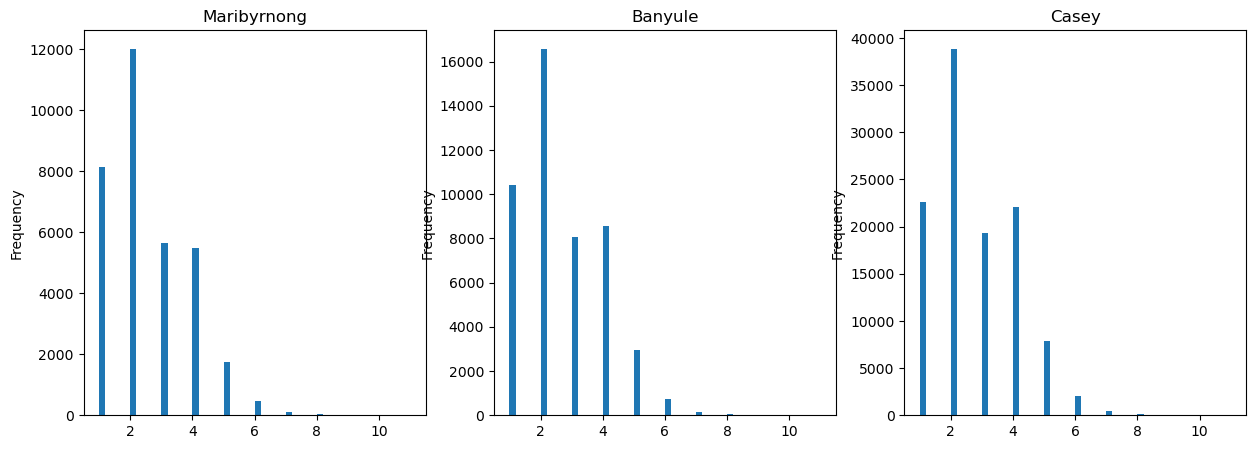

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
maribyrnong_df = df[df['LGA'] == 'Maribyrnong']
maribyrnong_df['hhsize'].plot(kind='hist', bins=50, ax=axs[0])

banyule = df[df['LGA'] == 'Banyule']
banyule['hhsize'].plot(kind='hist', bins=50, ax=axs[1])

casey = df[df['LGA'] == 'Casey']
casey['hhsize'].plot(kind='hist', bins=50, ax=axs[2])

axs[0].set_title('Maribyrnong') 
axs[1].set_title('Banyule') 
axs[2].set_title('Casey') 

In [73]:
df[df['LGA'] == 'Banyule'].describe()

,hhsize,totalvehs,hhinc
count,47610.000000,47610.000000,47610.000000
mean,2.590506,1.316635,1826.388805
std,1.323231,0.913441,1379.127115
min,1.000000,0.000000,0.000000
25%,2.000000,1.000000,725.000000
50%,2.000000,1.000000,1550.000000
75%,4.000000,2.000000,2500.000000
max,11.000000,9.000000,14000.000000


In [74]:
df[df['LGA'] == 'Maribyrnong'].describe()

,hhsize,totalvehs,hhinc
count,33695.000000,33695.000000,33695.000000
mean,2.493248,1.279359,1837.056655
std,1.301977,0.885191,1395.670484
min,1.000000,0.000000,0.000000
25%,2.000000,1.000000,725.000000
50%,2.000000,1.000000,1500.000000
75%,3.000000,2.000000,2500.000000
max,11.000000,9.000000,14000.000000


Text(0.5, 1.0, 'Casey')

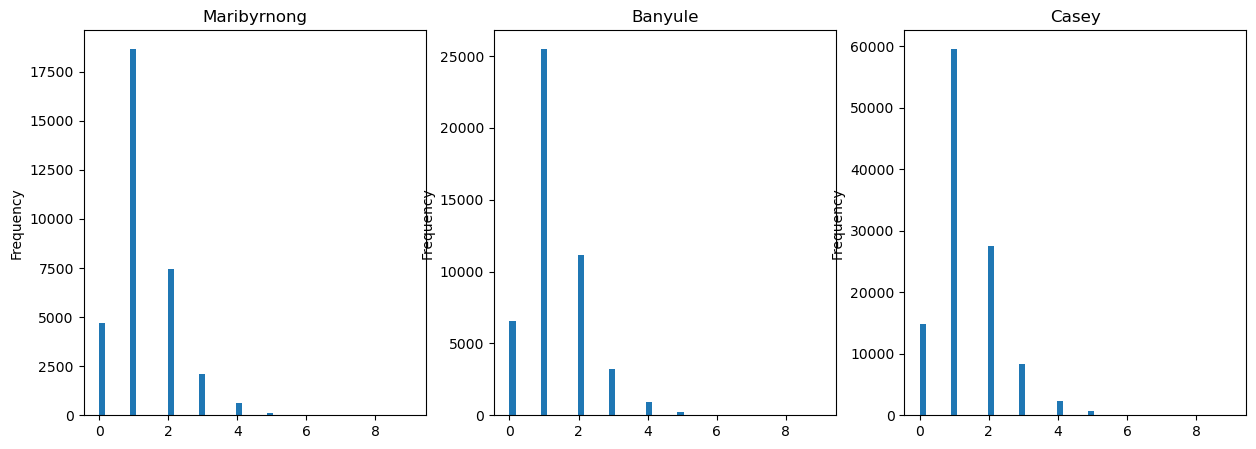

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
maribyrnong_df = df[df['LGA'] == 'Maribyrnong']
maribyrnong_df['totalvehs'].plot(kind='hist', bins=50, ax=axs[0])
banyule = df[df['LGA'] == 'Banyule']
banyule['totalvehs'].plot(kind='hist', bins=50, ax=axs[1])
casey = df[df['LGA'] == 'Casey']
casey['totalvehs'].plot(kind='hist', bins=50, ax=axs[2])

axs[0].set_title('Maribyrnong') 
axs[1].set_title('Banyule') 
axs[2].set_title('Casey') 

In [76]:
# own at least two cars or vans
#df['veh2'] = df[['cars', 'fourwds', 'utes', 'vans']].sum(axis=1) 
#df.loc[df['veh2'] < 2, 'veh2'] = 0
#df.loc[df['veh2'] >= 2, 'veh2'] = 1

In [77]:
hhsize_min = df['hhsize'].min()
hhsize_max = df['hhsize'].max()
totalvehs_min = df['totalvehs'].min()
totalvehs_max = df['totalvehs'].max()
hhinc_min = df['hhinc'].min()
hhinc_max = df['hhinc'].max()

print(f"hhsize: {hhsize_min}, {hhsize_max}")
print(f"totalbehs: {totalvehs_min}, {totalvehs_max}")
print(f"hinc: {hhinc_min}, {hhinc_max}")

hhsize: 1.0, 11.0
totalbehs: 0.0, 9.0
hinc: 0.0, 14000.0


## Remove Outliers 

In [78]:
"""
Q1 = np.percentile(df['hhsize'], 25)
Q3 = np.percentile(df['hhsize'], 75)
IQR = Q3 - Q1

# Define a threshold for outlier detection
threshold = 1.5

# Identify the outliers
outliers = (df['hhsize'] < Q1 - threshold * IQR) | (df['hhsize'] > Q3 + threshold * IQR)

# Remove the outliers
df_outliers = df.copy()
df = df[~outliers]
"""

"\nQ1 = np.percentile(df['hhsize'], 25)\nQ3 = np.percentile(df['hhsize'], 75)\nIQR = Q3 - Q1\n\n# Define a threshold for outlier detection\nthreshold = 1.5\n\n# Identify the outliers\noutliers = (df['hhsize'] < Q1 - threshold * IQR) | (df['hhsize'] > Q3 + threshold * IQR)\n\n# Remove the outliers\ndf_outliers = df.copy()\ndf = df[~outliers]\n"

In [79]:
#df_test = df.copy()
df_outliers = df.copy()
df['hhsize'] = winsorize(df['hhsize'], limits=[0.01, 0.01])

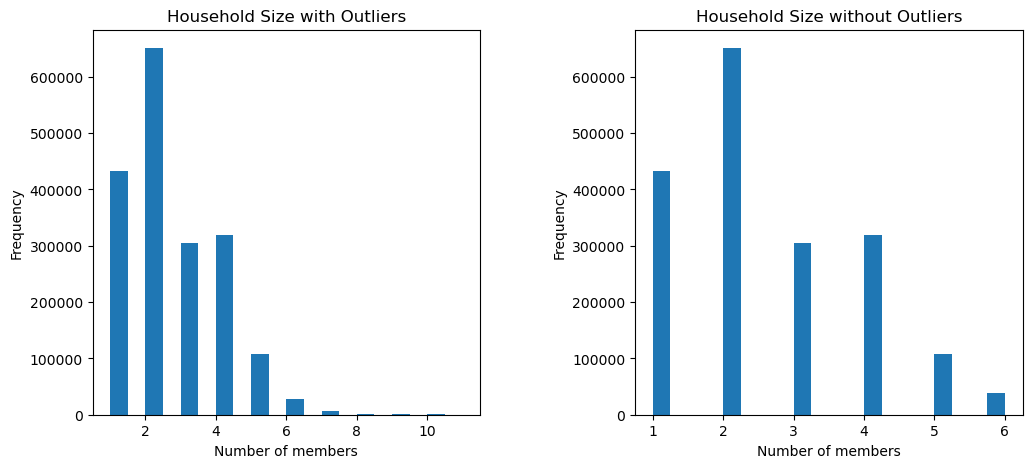

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.4)

axs[0].hist(df_outliers['hhsize'], bins=20)
axs[0].set_title('Household Size Before Winsorizing')
axs[0].set_xlabel('Number of members')
axs[0].set_ylabel('Frequency')


axs[1].hist(df['hhsize'], bins=20)
axs[1].set_title('Household Size After Winsorizing')
axs[1].set_xlabel('Number of members')
axs[1].set_ylabel('Frequency')

# Show the plot
plt.show()

In [93]:
"""
Q1 = np.percentile(df['totalvehs'], 25)
Q3 = np.percentile(df['totalvehs'], 75)
IQR = Q3 - Q1

# Define a threshold for outlier detection
threshold = 1.5

# Identify the outliers
outliers = (df['totalvehs'] < Q1 - threshold * IQR) | (df['totalvehs'] > Q3 + threshold * IQR)

# Remove the outliers
df_outliers = df.copy()
df = df[~outliers]
"""

"\nQ1 = np.percentile(df['totalvehs'], 25)\nQ3 = np.percentile(df['totalvehs'], 75)\nIQR = Q3 - Q1\n\n# Define a threshold for outlier detection\nthreshold = 1.5\n\n# Identify the outliers\noutliers = (df['totalvehs'] < Q1 - threshold * IQR) | (df['totalvehs'] > Q3 + threshold * IQR)\n\n# Remove the outliers\ndf_outliers = df.copy()\ndf = df[~outliers]\n"

In [82]:
#df_test = df.copy()
df_outliers = df.copy()
df['totalvehs'] = winsorize(df['totalvehs'], limits=[0.01, 0.01])

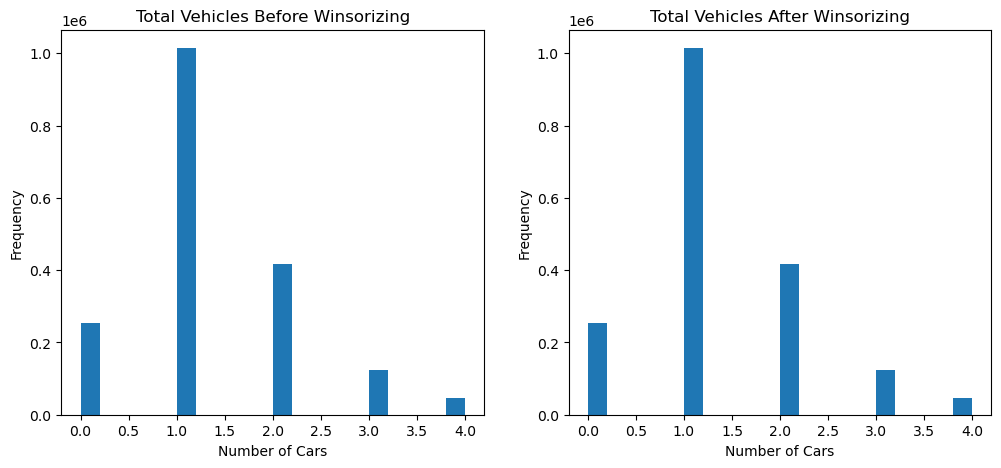

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))


axs[0].hist(df_outliers['totalvehs'], bins=20)
axs[0].set_title('Total Vehicles Before Winsorizing')
axs[0].set_xlabel('Number of Cars')
axs[0].set_ylabel('Frequency')
#axs[0].set_xlim([0, totalvehs_max])

axs[1].hist(df['totalvehs'], bins=20)
axs[1].set_title('Total Vehicles After Winsorizing')
axs[1].set_xlabel('Number of Cars')
axs[1].set_ylabel('Frequency')
#axs[1].set_xlim([0, totalvehs_max])


# Show the plot
plt.show()

In [84]:
"""
q_5 = df['hhinc'].quantile(0.01)
q_95 = df['hhinc'].quantile(0.99)

# Select only the values within the cutoff range
df_outliers = df.copy()
df = df[(df['hhinc'] >= q_5) & (df['hhinc'] <= q_95)]
"""

"\nq_5 = df['hhinc'].quantile(0.01)\nq_95 = df['hhinc'].quantile(0.99)\n\n# Select only the values within the cutoff range\ndf_outliers = df.copy()\ndf = df[(df['hhinc'] >= q_5) & (df['hhinc'] <= q_95)]\n"

In [85]:
#df_test = df.copy()
df_outliers = df.copy()
df['hhinc'] = winsorize(df['hhinc'], limits=[0.01, .01])

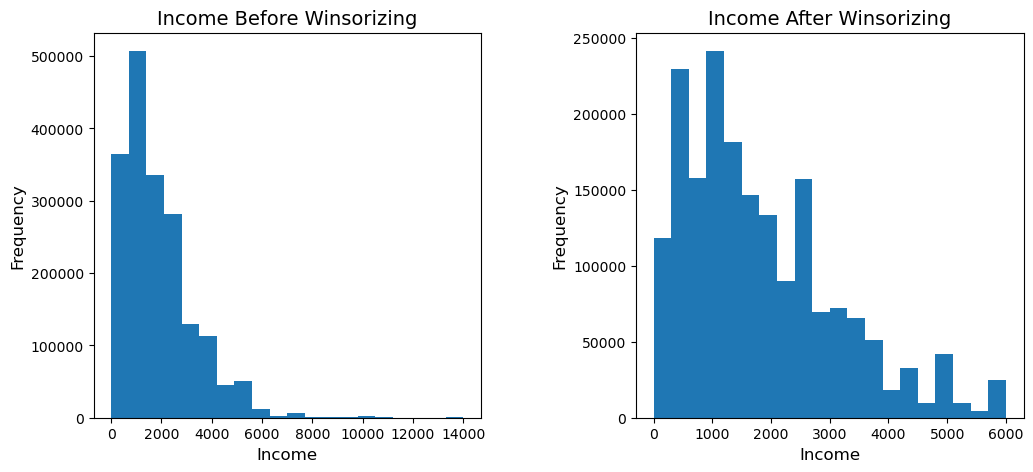

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].hist(df_outliers['hhinc'], bins=20)
axs[0].set_title('Income Before Winsorizing', fontsize=14)
axs[0].set_xlabel('Income', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].tick_params(axis='both', labelsize=10)

axs[1].hist(df['hhinc'], bins=20)
axs[1].set_title('Income After Winsorizing', fontsize=14)
axs[1].set_xlabel('Income', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)

# Increase padding between subplots
fig.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()


In [87]:
df_discrete = df[['LGA','dwelltype', 'owndwell']]
df_quantile = df[['hhinc']]
df_normalise = df[['hhsize', 'totalvehs']]

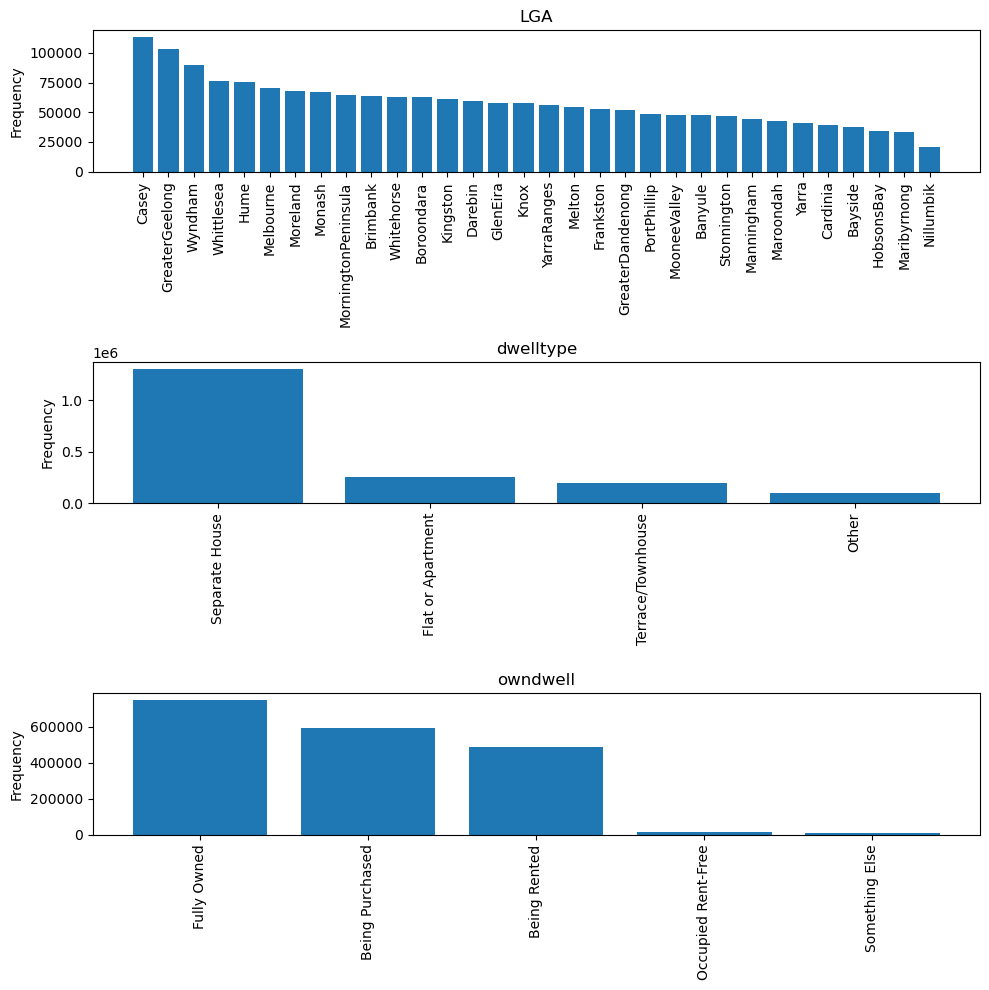

In [102]:
col_names = df_discrete.columns
# calculate the number of rows required
num_cols = 1
num_plots = len(col_names)
num_rows = (num_plots + num_cols - 1) // num_cols

# create the subplot grid
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))

# loop over columns and plot the frequency of each column's values
for i, col_name in enumerate(col_names):
    freq = df[col_name].value_counts()
    axs[i].bar(freq.index, freq.values)
    axs[i].set_title(col_name)
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_ylabel('Frequency')

# add spacing between subplots
plt.tight_layout()
plt.show()

In [103]:
col_names = df_normalise.columns
for col in col_names:
    df[f"{col}_normalised"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df.head()

,LGA,hhsize,totalvehs,dwelltype,hhinc,owndwell,hhsize_normalised,totalvehs_normalised
0,Banyule,1.0,1.0,Other,900.0,Fully Owned,0.0,0.25
1,Banyule,1.0,1.0,Separate House,3625.0,Being Purchased,0.0,0.25
2,Banyule,2.0,1.0,Separate House,1475.0,Fully Owned,0.2,0.25
3,Banyule,1.0,1.0,Separate House,0.0,Being Purchased,0.0,0.25
4,Banyule,2.0,1.0,Separate House,1225.0,Fully Owned,0.2,0.25


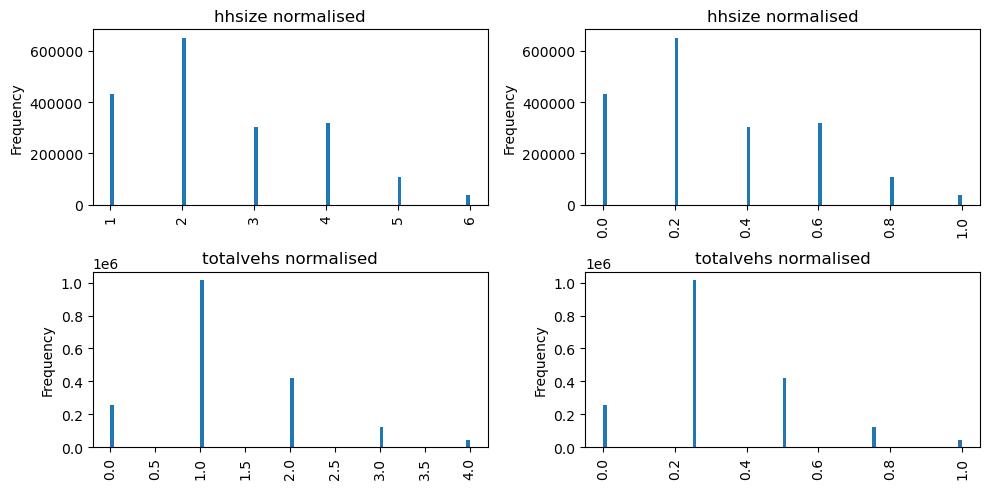

In [104]:
num_cols = 2
num_rows = len(col_names)

# create the subplot grid
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 5))

# loop over columns and plot the frequency of each column's values
for i, col_name in enumerate(col_names):
    axs[i, 0].hist(df[col_name], bins=100)
    axs[i, 0].set_title(f"{col_name} normalised")
    axs[i, 0].tick_params(axis='x', rotation=90)
    axs[i, 0].set_ylabel('Frequency')

    axs[i, 1].hist(df[f'{col_name}_normalised'], bins=100)
    axs[i, 1].set_title(f"{col_name} normalised")
    axs[i, 1].tick_params(axis='x', rotation=90)
    axs[i, 1].set_ylabel('Frequency')

# add spacing between subplots
plt.tight_layout()

# show the plot
plt.show()

In [96]:
qt = QuantileTransformer(output_distribution='uniform')
df['hhinc_normalised'] = qt.fit_transform(df[['hhinc']])

NameError: name 'col' is not defined

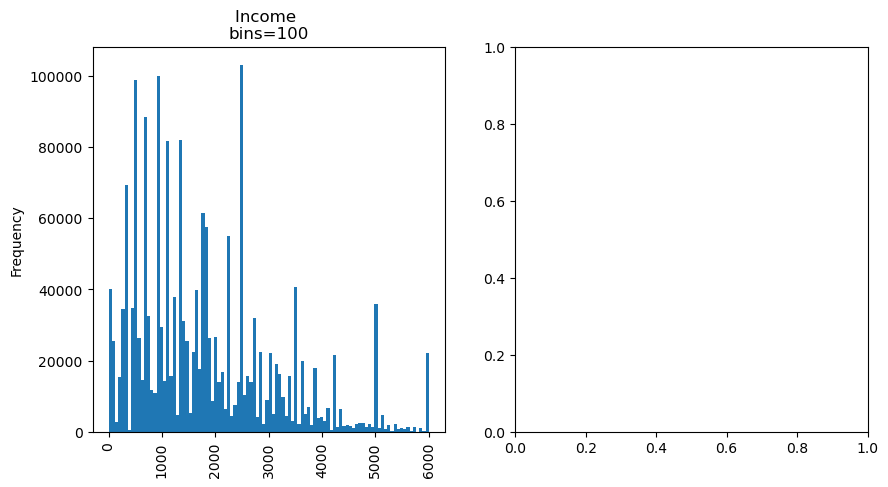

In [97]:
col_names = df_quantile.columns
# calculate the number of rows required
num_cols = 2
num_rows = len(col_names)

# create the subplot grid
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 5))
for col_name in col_names:
    axs[0].hist(df[col_name], bins=100)
    axs[0].set_title(f"Income \nbins=100")
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_ylabel('Frequency')
    axs[0].set_ylabel(col)

    axs[1].hist(df[f'{col_name}_normalised'], bins=200)
    axs[1].set_title(f"Income \nbins=100")
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].set_ylabel('Frequency')

# add spacing between subplots
plt.tight_layout()

# show the plot
plt.show()

In [ ]:

'''
# loop over columns and plot the frequency of each column's values
for i, col_name in enumerate(col_names):
    axs[i, 0].hist(df[col_name], bins=100)
    axs[i, 0].set_title(f"{col_name} bins=100")
    axs[i, 0].tick_params(axis='x', rotation=90)
    axs[i, 0].set_ylabel('Frequency')

    axs[i, 1].hist(df[f'{col_name}_normalized'], bins=100)
    axs[i, 1].set_title(f"{col_name} bins=100")
    axs[i, 1].tick_params(axis='x', rotation=90)
    axs[i, 1].set_ylabel('Frequency')
'''

In [107]:
df.head()

,LGA,hhsize,totalvehs,dwelltype,hhinc,owndwell,hhsize_normalised,totalvehs_normalised,hhinc_normalised
0,Banyule,1.0,1.0,Other,900.0,Fully Owned,0.0,0.25,0.300801
1,Banyule,1.0,1.0,Separate House,3625.0,Being Purchased,0.0,0.25,0.899900
2,Banyule,2.0,1.0,Separate House,1475.0,Fully Owned,0.2,0.25,0.490991
3,Banyule,1.0,1.0,Separate House,0.0,Being Purchased,0.0,0.25,0.000000
4,Banyule,2.0,1.0,Separate House,1225.0,Fully Owned,0.2,0.25,0.416416


## One hot encoding

In [108]:
df = pd.get_dummies(df, columns=['dwelltype', 'owndwell'])

In [109]:
df.head()

,LGA,hhsize,totalvehs,hhinc,hhsize_normalised,totalvehs_normalised,hhinc_normalised,dwelltype_Flat or Apartment,dwelltype_Other,dwelltype_Separate House,dwelltype_Terrace/Townhouse,owndwell_Being Purchased,owndwell_Being Rented,owndwell_Fully Owned,owndwell_Occupied Rent-Free,owndwell_Something Else
0,Banyule,1.0,1.0,900.0,0.0,0.25,0.300801,0,1,0,0,0,0,1,0,0
1,Banyule,1.0,1.0,3625.0,0.0,0.25,0.899900,0,0,1,0,1,0,0,0,0
2,Banyule,2.0,1.0,1475.0,0.2,0.25,0.490991,0,0,1,0,0,0,1,0,0
3,Banyule,1.0,1.0,0.0,0.0,0.25,0.000000,0,0,1,0,1,0,0,0,0
4,Banyule,2.0,1.0,1225.0,0.2,0.25,0.416416,0,0,1,0,0,0,1,0,0


In [110]:
df.to_csv('clean_data.csv', index=False)